In [1]:
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from pathlib import Path
root_path = Path.cwd().parent.absolute()
import sys
sys.path.append(str(root_path))
import os

In [2]:

from flax import nnx
import jax
import jax.numpy as jnp

In [3]:
from geometry.G_matrix import G_matrix
from functionals.functions import create_potentials
from functionals.linear_funcitonal_class import LinearPotential
from functionals.internal_functional_class import InternalPotential
from functionals.interaction_functional_class import InteractionPotential
from functionals.functional import Potential
from flows.anderson_acceleration import anderson_method
from parametric_model.parametric_model import ParametricModel


In [4]:
# Define the parametric model
parametric_model = ParametricModel(
    parametric_map="resnet", # "node" "resnet"
    architecture=[2, 2, 64], # [input_dim, num_layers, hidden_width]
    activation_fn="tanh", # "tanh", "relu", "SinTu", "identity", "sigmoid", "gelu", "swish"
    time_dependent=False,    # True or False
    solver="euler", # "euler" or "heun"
    dt0=0.1,
    rhs_model="mlp", # "mlp" or "resnet"
    ref_density="gaussian",
    scale_factor=2.5e-2
)
# _,current_params  = nnx.split(parametric_model)

In [5]:
# Anderson parameters
h = 1e-2 # Time step size
m = 8 # Number of previous iterates to consider
beta = 1.25 # Damping parameter
max_iterations = 250
tolerance = 1e-5
n_samples = 10_000  # Monte Carlo sample size

key = jax.random.PRNGKey(1234)
rngs = nnx.Rngs(key)


# Generate reference samples from λ = N(0, I)
key, subkey = jax.random.split(key)
z_samples = jax.random.normal(subkey, (n_samples, 2))

G_mat_flow = G_matrix(parametric_model)

solver= 'cg' # minres or cg


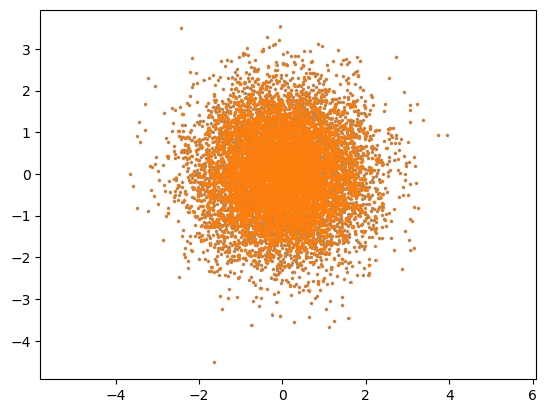

In [6]:
import matplotlib.pyplot as plt
y = parametric_model(z_samples)
plt.scatter(y[:,0], y[:,1], s=1)
plt.scatter(z_samples[:,0], z_samples[:,1], s=5, marker = '*', alpha = 0.5)
plt.axis('equal')
plt.show()

In [7]:
from functionals.functions import double_well_potential_fn, styblinski_tang_potential_fn, aggregation_potential_fn,zero_potential_fn
linear_potential = LinearPotential(potential_fn= zero_potential_fn, coeff = 1.0)
internal_potential = InternalPotential(functional='entropy', coeff = 10, method= 'exact',prob_dim=2)
interaction_potential = InteractionPotential(interaction_fn = aggregation_potential_fn, coeff = 1, a = 4, b = 2)

potential = Potential(linear = linear_potential,
                      internal = None,
                      interaction = interaction_potential)

Starting Anderson-accelerated gradient flow
  n_iterations: 250
  step_size: 0.01
  memory_size: 8
  mixing_parameter: 1.25
------------------------------------------------------------
Iter    0 | Energy: 2.011383e+00 | Residual: 3.652439e-01 | 


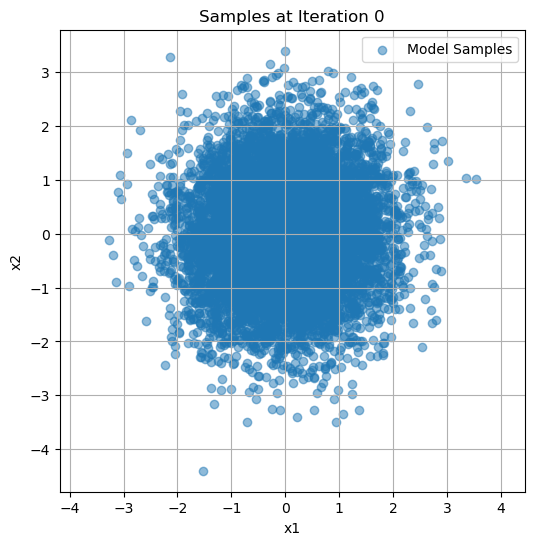

/work/Sebas/BV_Hamiltonian/Parametric_BV_Hamiltonian/geometry/lin_alg_solvers.py:133: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  Tk_under = jnp.zeros((k + 1, k), dtype=jnp.float64)
/work/Sebas/BV_Hamiltonian/Parametric_BV_Hamiltonian/geometry/lin_alg_solvers.py:140: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  rhs = jnp.zeros((k + 1,), dtype=jnp.float64).at[0].set(beta1)


Iter   10 | Energy: -8.475399e-03 | Residual: 5.294777e-03 | 


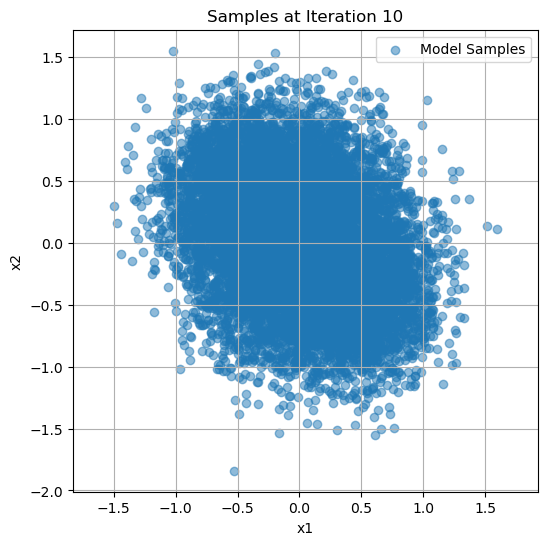

KeyboardInterrupt: 

In [9]:
current_params, history = anderson_method(
    parametric_model=parametric_model,
    batch_size=n_samples,
    test_data_set=z_samples,
    G_mat=G_mat_flow,
    potential=potential,
    initial_params= None,
    n_iterations=max_iterations,
    step_size=h,
    memory_size=m,
    mixing_parameter=beta,
    anderson_tol=1e-5,
    solver = solver,
    solver_tol=tolerance,
    solver_maxiter=10
)

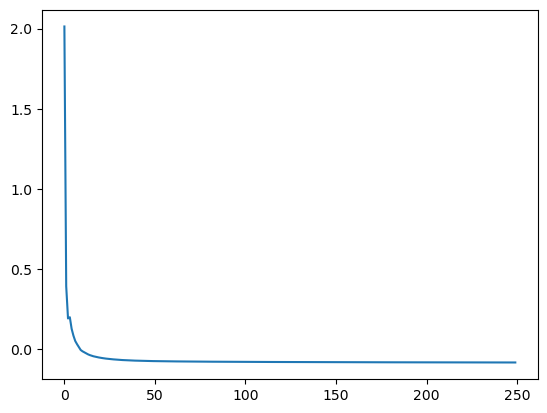

In [22]:
import matplotlib.pyplot as plt
plt.plot(history['energies'])